In [17]:
from PIL import Image
from pathlib import Path
import json
import imagehash
from bitarray import bitarray
import numpy as np
import tqdm
import matplotlib.pyplot as plt

### db

In [2]:
json_path ='../../backend/flask-app/storage/records.json'
with open(json_path) as f:
    db_data = json.load(f)
res = []
for o in db_data:
    res.append((o['object_id'],
                bitarray(o['aHash']),
                bitarray(o['pHash']),
                bitarray(o['dHash']),
                bitarray(o['wHash'])))
object_id, ahash, phash, dhash, whash = zip(*res)
db = {
    'object_id': object_id,
    'ahash': ahash,
    'phash': phash,
    'dhash': dhash,
    'whash': whash,
}

### pic

In [3]:
PIC_PATH = Path('../dataset/images')

In [4]:
true_map_path = '../annotation/true_map.csv'
with open(true_map_path) as f:
    true_map_raw = f.read()
true_map = [o.split(',') for o in true_map_raw.split('\n')][:-1]
name, object_id = zip(*true_map)
pic = {
    'name': name,
    'object_id': object_id,
}

In [5]:
crop_path = '../annotation/crop.txt'
with open(crop_path) as f:
    crop_raw = f.read()
crop_lines = crop_raw.split('\n')[:-1]
def split_line(line):
    com = line.index(',')
    name = line[:com]
    crops = line[com+1:]
    l1, l2, l3 = crops.split(',{')
    l1 = json.loads(l1)
    l2 = json.loads('{' + l2)
    l3 = json.loads('{' + l3)
    return name,l1,l2,l3
crops = [split_line(o) for o in crop_lines]

In [6]:
# combine
dic = {name: i for i,name in enumerate(pic['name'])}
l1s = [None] * len(pic['name'])
l2s = [None] * len(pic['name'])
l3s = [None] * len(pic['name'])
for name, l1, l2, l3 in crops:
    i = dic[name]
    l1s[i] = l1;l2s[i] = l2;l3s[i] = l3
pic['l1'] = l1s;pic['l2'] = l2s;pic['l3'] = l3s

# test crop

In [7]:
 # (left, upper, right, lower)-tuple.
def to_box(image, crop):
    width, height = image.size
    x, y, w, h = crop['x']/100, crop['y']/100, crop['width']/100, crop['height']/100
    x1 = int(x * width)
    y1 = int(y * height)
    x2 = int((x + w) * width) - 1
    y2 = int((y + h) * height) - 1
    return (x1, y1, x2, y2)

In [8]:
def get_matched_index(i, hfunc, nfunc, level):
    name = pic['name'][i]
    image_path = PIC_PATH / name
    image = Image.open(image_path)
    crop = pic[level][i]
    target_id = pic['object_id'][i]
    #
    c_image = image.crop(to_box(image, crop))
    c_image.load()
    raw_hash = ''.join(list(hfunc(c_image).hash.flatten().astype(int).astype(str)))
    h = bitarray(raw_hash)
    #
    idx = np.argsort([(h ^ h1).count(1) for h1 in db[nfunc]])
    matched = [db['object_id'][i] for i in idx]
    return matched.index(target_id), matched

In [9]:
hash_opts = [
    (imagehash.average_hash, 'ahash'),
    (imagehash.phash, 'phash'),
    (imagehash.dhash, 'dhash'),
    (imagehash.whash, 'whash'),
]
l_opts = ['l1', 'l2', 'l3']
midx_dict = {}
for hfunc, nfunc in hash_opts:
    for l in l_opts:
        print(nfunc, l)
        midx = []; marray = []
        for i in tqdm.tqdm(list(range(len(pic['name'])))):
            mi, ma = get_matched_index(i, hfunc, nfunc, l)
            midx.append(mi)
            marray.append(ma)
        midx = np.array(midx)
        marray = np.array(marray)
        midx_dict[(nfunc, l)] = (midx, marray)

  0%|          | 0/108 [00:00<?, ?it/s]

ahash l1


  1%|          | 1/108 [00:00<00:20,  5.32it/s]

ahash l2


  0%|          | 0/108 [00:00<?, ?it/s]

ahash l3


  0%|          | 0/108 [00:00<?, ?it/s]

phash l1


  1%|          | 1/108 [00:00<00:21,  5.03it/s]

phash l2


  1%|          | 1/108 [00:00<00:21,  5.07it/s]

phash l3


  0%|          | 0/108 [00:00<?, ?it/s]

dhash l1


  1%|          | 1/108 [00:00<00:21,  5.09it/s]

dhash l2


  1%|          | 1/108 [00:00<00:20,  5.13it/s]

dhash l3


  0%|          | 0/108 [00:00<?, ?it/s]

whash l1


  0%|          | 0/108 [00:00<?, ?it/s]

whash l2


  0%|          | 0/108 [00:00<?, ?it/s]

whash l3


100%|██████████| 108/108 [00:33<00:00,  3.21it/s]


In [10]:
for hfunc, nfunc in hash_opts:
    for l in l_opts:
        print(nfunc, l)
        midx = midx_dict[(nfunc, l)][0]
        print(np.sum(midx==0), np.sum(midx<5), np.sum(midx<10))

ahash l1
68 82 85
ahash l2
72 81 84
ahash l3
73 80 83
phash l1
96 102 102
phash l2
97 105 105
phash l3
99 104 106
dhash l1
86 95 97
dhash l2
94 95 95
dhash l3
91 97 99
whash l1
55 71 76
whash l2
68 75 80
whash l3
65 75 76


## vis

In [25]:
bars1[0], bars2[0], bars3[0]

(0.7592592592592593, 0.75, 0.7407407407407407)

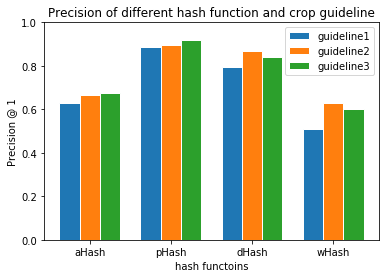

In [42]:
def plot(K=1):
    barWidth = 0.25
    bars1 = []
    bars2 = []
    bars3 = []
    for hfunc, nfunc in hash_opts:
        midx1 = midx_dict[(nfunc, 'l1')][0]
        bars1.append(np.sum(midx1 < K)/108)
        midx2 = midx_dict[(nfunc, 'l2')][0]
        bars2.append(np.sum(midx2 < K)/108)
        midx3 = midx_dict[(nfunc, 'l3')][0]
        bars3.append(np.sum(midx3 < K)/108)
    #
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    #
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='guideline1')
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='guideline2')
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='guideline3')
    # Add xticks on the middle of the group bars
    plt.xlabel('hash functoins')
    plt.ylabel('Precision @ {}'.format(K))
    plt.xticks([r + barWidth for r in range(len(bars1))], ['aHash', 'pHash', 'dHash', 'wHash'])

    # Create legend & Show graphic
    plt.title('Precision of different hash function and crop guideline')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
plot(1)

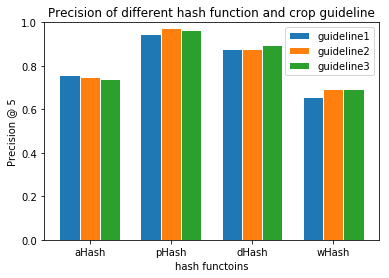

In [43]:
plot(5)

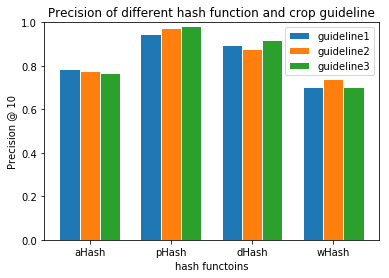

In [44]:
plot(10)